### Exercise 2 - Create a model to predict customer churn

### 0. Import packages

In [108]:
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline as sk_pipe
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, make_scorer
from sklearn.metrics import auc, precision_recall_curve
from sklearn import set_config
set_config(transform_output="pandas")
from xgboost import XGBClassifier

### 1. Data Preparation

#### Read the data

In [2]:
path = '~/Documents/Git/Qustodio-Technical-Test/'
sales = pd.read_csv(os.path.join(path, 'sales.csv'))
user_activity = pd.read_csv(os.path.join(path, 'user_activity.csv'))

In [3]:
sales.head()

,order_id,account_id,start_date,plan,amount,currency,Unnamed: 6
0,C5G1ckzVUC1V,36369294,2019-03-17,MEDIUM,12.95,EUR,NaN
1,LyPKxILXvkiu,36369294,2019-04-17,MEDIUM,12.95,EUR,NaN
2,729R0C9dVx49,36369294,2019-05-17,MEDIUM,12.95,EUR,NaN
3,RrxBXQYG9Qn8,13708705,2020-08-28,SMALL,8.95,EUR,NaN
4,iYemtey2MjLT,940537915,2020-07-17,SMALL,8.95,EUR,NaN


In [4]:
user_activity.head()

,account_id,gender,genre1,genre2,type,games,age,hours
0,101530,male,role-playing,action,mobile,8,21,7.573853
1,731892,female,adventure,action,computer,9,25,4.620231
2,856432,male,action,role-playing,mobile,19,35,13.608988
3,1425820,male,adventure,adventure,mobile,8,20,8.648719
4,1881252,male,action,strategy,computer,6,18,8.929738


#### Data Exploration & Cleaning

In [5]:
sales.dtypes

order_id        object
 account_id      int64
 start_date     object
 plan           object
 amount        float64
 currency       object
Unnamed: 6     float64
dtype: object

Unnamed: 6 column should be dropped and we should change the data type of start_date column. Additionally, some column appear to have a trailing whitespace that needs cleaning.

In [6]:
sales = sales.rename(columns=lambda x: x.strip()) # removes the trailing whitespace
sales['start_date'] = pd.to_datetime(sales.start_date) # transforms start_date into a datetime format
sales.drop(columns= 'Unnamed: 6', inplace= True) # removes the undesired column

In [7]:
sales.describe(include=['O'])

,order_id,plan,currency
count,14788,14788,14788
unique,14788,3,2
top,C5G1ckzVUC1V,SMALL,USD
freq,1,12440,7413


In [8]:
sales.isna().sum()

order_id      0
account_id    0
start_date    0
plan          0
amount        0
currency      0
dtype: int64

No NaN values have been found.

In [9]:
sales[sales.duplicated()]

,order_id,account_id,start_date,plan,amount,currency


No duplicates have been found.

In [10]:
user_activity.dtypes

account_id      int64
gender         object
genre1         object
genre2         object
type           object
games           int64
age             int64
hours         float64
dtype: object

In [11]:
user_activity.describe(include=['O'])

,gender,genre1,genre2,type
count,2000,2000,2000,2000
unique,2,6,6,3
top,male,action,adventure,computer
freq,1400,588,555,1250


In [12]:
user_activity.describe()

,account_id,games,age,hours
count,2.000000e+03,2000.000000,2000.000000,2000.000000
mean,5.073399e+08,8.157500,25.997000,9.134307
std,2.890714e+08,4.880226,6.093238,4.324985
min,1.015300e+05,0.000000,15.000000,0.000000
25%,2.565783e+08,5.000000,22.000000,6.340461
50%,5.040000e+08,8.000000,25.000000,8.635053
75%,7.549967e+08,11.000000,29.000000,11.566813
max,9.996430e+08,33.000000,55.000000,30.000000


In [13]:
user_activity.isna().sum()

account_id    0
gender        0
genre1        0
genre2        0
type          0
games         0
age           0
hours         0
dtype: int64

No NaN values have been found.

In [14]:
user_activity[user_activity.duplicated()]

,account_id,gender,genre1,genre2,type,games,age,hours


No duplicate values have been found.

In [15]:
# set indexes for both dataframes
sales.set_index('order_id', inplace= True)
user_activity.set_index('account_id', inplace= True)

### 2. Create Churn Label

In [16]:
number_of_orders = sales.groupby(by=['account_id']).count()['start_date'].to_frame().reset_index() # checking how many purchases have been made by each user
first_order_date = sales.groupby('account_id')['start_date'].min().reset_index() # extracts the date of the first purchase for each user
last_order_date = sales.groupby('account_id')['start_date'].max().reset_index() # extracts the date of the last purchase for each user

useful_information_sales = number_of_orders.merge(first_order_date, how= 'left', on= 'account_id').merge(last_order_date, how='left', on='account_id')
useful_information_sales.rename(columns= {'start_date_x': 'Orders', 'start_date_y': 'Date_First_Order', 'start_date': 'Date_Last_Order'}, inplace= True) # renames column after the left merge

useful_information_sales = useful_information_sales.merge(sales[['account_id', 'plan', 'currency']], how= 'left', on= 'account_id') # extracts additional useful information from sales dataframe
useful_information_sales.drop_duplicates(inplace=True)
useful_information_sales

,account_id,Orders,Date_First_Order,Date_Last_Order,plan,currency
0,101530,4,2019-09-03,2019-12-03,SMALL,EUR
4,731892,11,2020-02-12,2020-12-12,SMALL,EUR
15,856432,12,2020-01-25,2020-12-25,SMALL,EUR
27,1425820,2,2019-06-25,2019-07-25,SMALL,EUR
29,1881252,1,2019-12-22,2019-12-22,SMALL,USD
...,...,...,...,...,...,...
14739,998101168,3,2020-10-13,2020-12-13,SMALL,EUR
14742,998103378,3,2020-03-14,2020-05-14,SMALL,EUR
14745,998392913,18,2019-07-03,2020-12-03,MEDIUM,USD
14763,999546295,17,2019-03-19,2020-07-19,SMALL,EUR


In [17]:
# build the dataframe to be used to modelling with info from sales.csv and user_actiity.csv
model_df = user_activity.merge(useful_information_sales, how= 'left', on= 'account_id')

assert model_df.shape[0]==user_activity.shape[0], 'Error! There are duplicates in the data'

del useful_information_sales, sales, user_activity # release memory by deleting dataframes that won't be used anymore
gc.collect()

0

In [18]:
model_df.head()

,account_id,gender,genre1,genre2,type,games,age,hours,Orders,Date_First_Order,Date_Last_Order,plan,currency
0,101530,male,role-playing,action,mobile,8,21,7.573853,4,2019-09-03,2019-12-03,SMALL,EUR
1,731892,female,adventure,action,computer,9,25,4.620231,11,2020-02-12,2020-12-12,SMALL,EUR
2,856432,male,action,role-playing,mobile,19,35,13.608988,12,2020-01-25,2020-12-25,SMALL,EUR
3,1425820,male,adventure,adventure,mobile,8,20,8.648719,2,2019-06-25,2019-07-25,SMALL,EUR
4,1881252,male,action,strategy,computer,6,18,8.929738,1,2019-12-22,2019-12-22,SMALL,USD


In [19]:
# Create Test set to do Predictions for Exercise 3
model_df['Date_Last_Order'] = model_df['Date_Last_Order'].dt.to_period('M') # extract only the year and month from the last order date

test_df = model_df[(model_df.Date_Last_Order==model_df.Date_Last_Order.max()) & (model_df.Orders>2) & (model_df.Orders<7)] # saving this dataframe in a variable for predictions
train_df = model_df[~model_df.account_id.isin(list(test_df.account_id.unique()))] # remove prediction users from train set

assert train_df.shape[0] == (model_df.shape[0] - test_df.shape[0]), 'Error! Wrong users have been removed from train_df'

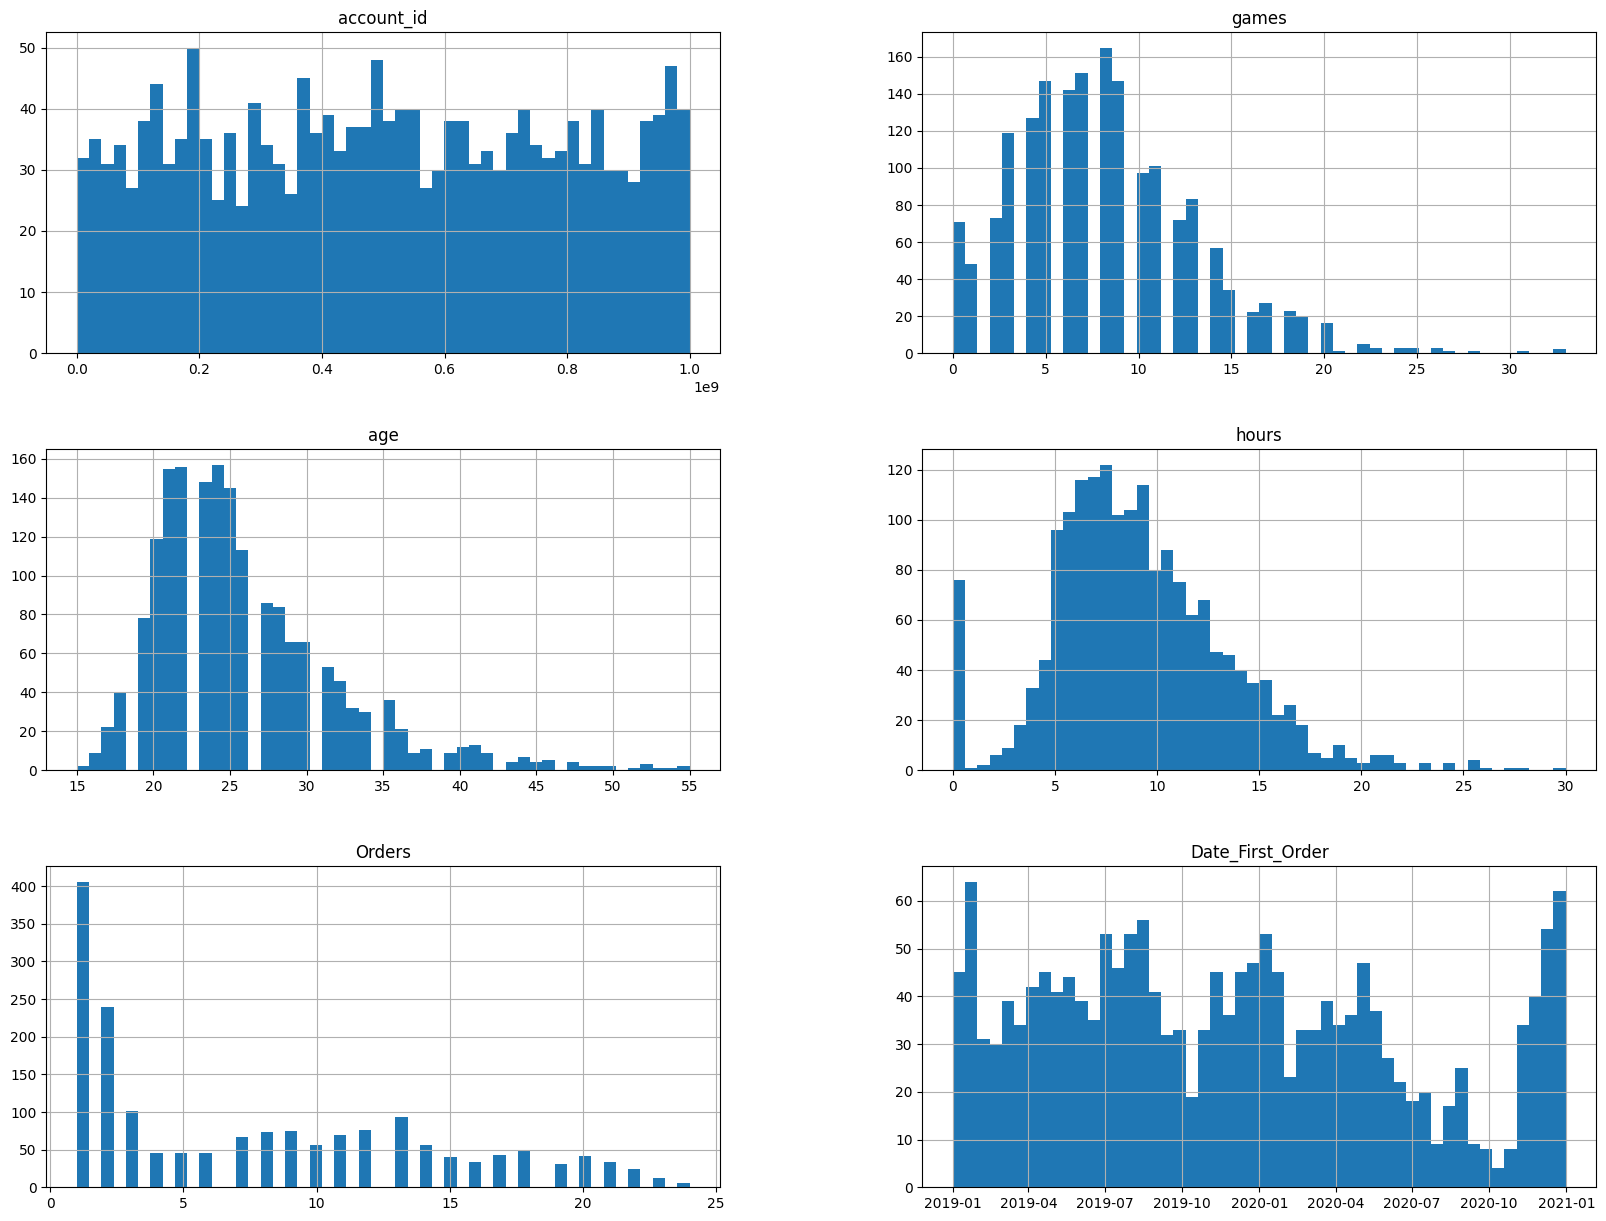

In [20]:
%matplotlib inline
train_df.hist(bins = 50, figsize = (20, 15))
plt.show()

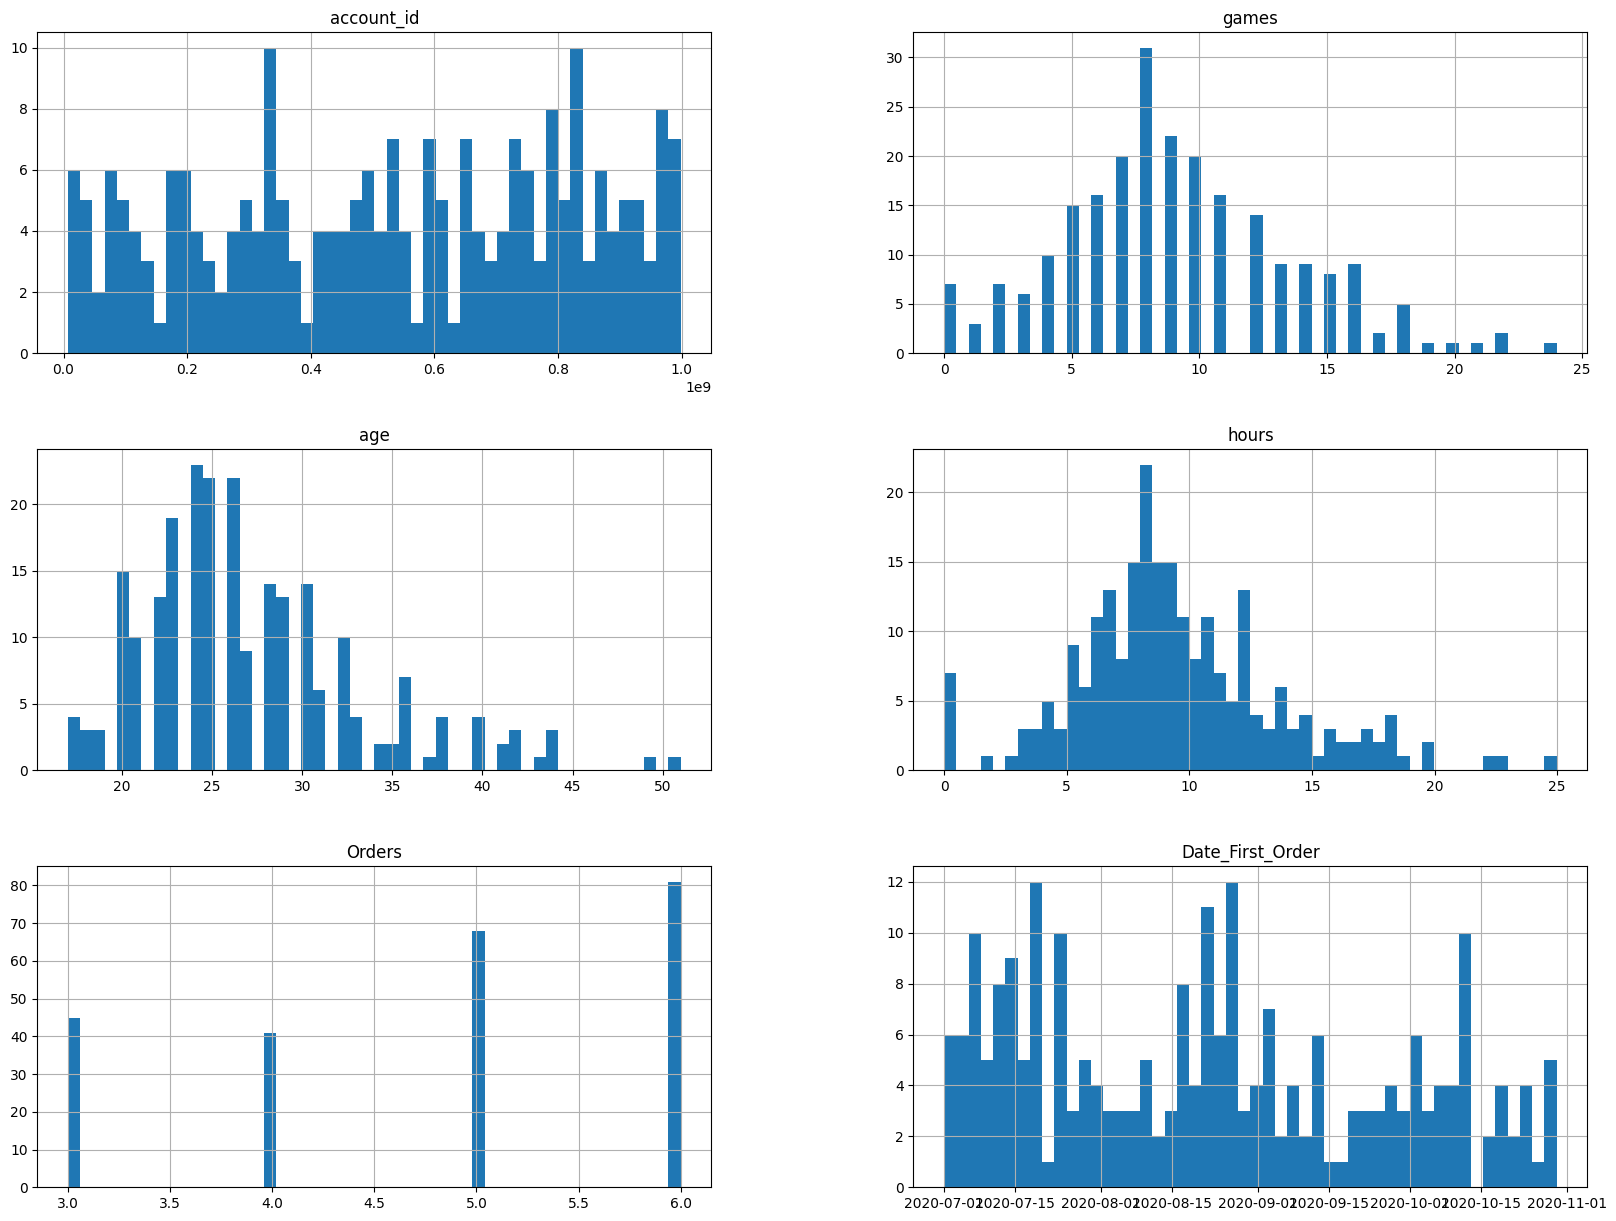

In [21]:
%matplotlib inline
test_df.hist(bins = 50, figsize = (20, 15))
plt.show()

For Exercise 3 we only want to predict on customers that have at least 3 months of order payments and we don't know if they will become churners or not, hence they have to have less than 7 months of order payments.

In [22]:
# Remove users with less than 2 Orders
train_df = train_df[train_df.Orders>2]

# Create Churn Label
train_df['Churn'] = 0
train_df.loc[train_df.Orders<7, 'Churn'] = 1

### 3. Feature Engineering

In [23]:
# Separate labels from features

labels = train_df[['Churn']].copy()
train_df.drop(columns=['Churn', 'Orders'], inplace= True) # drop Churn and Orders features from train set
test_df.drop(columns='Orders', inplace= True) # drop Orders from test set to remove target variable bias
len(labels[labels.Churn==1]) / len(labels) * 100 # explore Target variable distribution

/var/folders/hs/t_th7f6j6tsb1fg2d7_808y80000gn/T/ipykernel_35225/3572072172.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns='Orders', inplace= True) # drop Orders from test set to remove target variable bias


21.26899016979446

In [24]:
# Separate Categorical variables from Numerical variables

train_df.set_index('account_id', inplace= True)
train_df_cat = train_df[['gender', 'genre1', 'genre2', 'type', 'plan', 'currency']]
train_df_num = train_df[['games', 'age', 'hours']]

list_cat = train_df_cat.columns.to_list()
list_num = train_df_num.columns.to_list()

In [25]:
# Create the pipelines for both data types

cat_pipepline = sk_pipe([('encoder', OneHotEncoder(categories= 'auto', drop= 'first', sparse_output=False))])
num_pipeline = sk_pipe([('std_scaler', StandardScaler())])

# Apply the pipelines

pipeline_train_df_cat = cat_pipepline.fit_transform(train_df_cat)
pipeline_train_df_num = num_pipeline.fit_transform(train_df_num)

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, list_num),
    ('cat', cat_pipepline, list_cat),
])

full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('std_scaler',
                                                  StandardScaler())]),
                                 ['games', 'age', 'hours']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['gender', 'genre1', 'genre2', 'type', 'plan',
                                  'currency'])])

In [26]:
# Apply the data transformation pipeline to the train set

df_train_prepared = full_pipeline.fit_transform(train_df)
df_train_prepared

,num__games,num__age,num__hours,cat__gender_male,cat__genre1_adventure,cat__genre1_role-playing,cat__genre1_simulation,cat__genre1_sports,cat__genre1_strategy,cat__genre2_adventure,cat__genre2_role-playing,cat__genre2_simulation,cat__genre2_sports,cat__genre2_strategy,cat__type_mobile,cat__type_tablet,cat__plan_ MEDIUM,cat__plan_ SMALL,cat__currency_ USD
account_id,,,,,,,,,,,,,,,,,,,
101530,-0.110475,-0.972409,-0.333935,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
731892,0.087004,-0.333744,-1.004339,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
856432,2.061794,1.262918,1.035902,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2397506,0.876920,0.783920,-0.429749,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2436396,0.284483,-0.333744,1.227960,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998070356,-1.492829,-0.333744,-0.874152,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
998103378,-0.900392,-0.972409,-0.174363,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
998392913,0.876920,2.380582,0.038148,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [27]:
# Apply the data transformation pipeline to the test set

df_test_prepared = full_pipeline.fit(train_df) # fit it to the train set so we don't skew the StandardScaler imputer
df_test_prepared = full_pipeline.transform(test_df)
df_test_prepared

,num__games,num__age,num__hours,cat__gender_male,cat__genre1_adventure,cat__genre1_role-playing,cat__genre1_simulation,cat__genre1_sports,cat__genre1_strategy,cat__genre2_adventure,cat__genre2_role-playing,cat__genre2_simulation,cat__genre2_sports,cat__genre2_strategy,cat__type_mobile,cat__type_tablet,cat__plan_ MEDIUM,cat__plan_ SMALL,cat__currency_ USD
15,-0.110475,-0.493410,-0.022819,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
16,-0.702912,-0.653076,0.712051,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
17,-1.295350,2.380582,0.751735,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
24,1.469357,0.624254,-0.273823,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
30,1.469357,0.783920,0.538317,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1982,-1.097871,0.304921,0.328910,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1983,-0.110475,1.422585,-0.395851,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1984,-0.307954,-1.611074,-0.106571,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1992,-0.110475,-1.132075,0.854035,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 4. Model Building & Evaluation

In [30]:
# Using train_test split from sklearn - Holdout Method

X_train, X_val, labels_train, labels_val = train_test_split(train_df, labels, test_size = 0.2, random_state = 0, stratify = labels, shuffle = True) # use stratify method to preserve target class distribution

full_pipeline.fit(X_train) # fit the pipeline on train data to avoid data leakage between train and validation
X_train_prepared = full_pipeline.transform(X_train)
X_val_prepared = full_pipeline.transform(X_val)

In [73]:
def model_train(model):
    """
    Train a machine learning model on a prepared training dataset and make predictions on a validation dataset.

    Parameters:
    - model: An instance of a machine learning classifier (e.g., scikit-learn classifier).

    Returns:
    - y_pred_model: Predicted labels on the validation dataset.

    This function trains the provided machine learning model on the training dataset (X_train_prepared and labels_train).
    It then uses the trained model to make predictions on the validation dataset (X_val_prepared) and returns the predicted labels.

    Usage:
    - Call this function with a pre-initialized machine learning model to train it and obtain validation predictions.

    Example:
    y_pred = model_train(model)
    """
    model_clf = model
    model_clf.fit(X_train_prepared, labels_train)
    y_pred_model = model_clf.predict(X_val_prepared)
    
    return model_clf, y_pred_model


In [104]:
def model_eval(model, validation_predictions):
    """
    Evaluate the performance of a machine learning model by calculating various metrics including accuracy, confusion matrix,
    sensitivity, specificity, precision (PPV), NPV, and F1 score.

    Parameters:
    - model: A trained machine learning model.
    - validation_predictions: Predicted labels from the model on the validation dataset.

    Returns:
    - recall: Sensitivity score.
    - specificity: Specificity score.
    - precision: Precision (Positive Predictive Value) score.
    - npv: Negative Predictive Value score.
    - f1_score: F1 score (harmonic mean of precision and recall).

    This function calculates and prints the following metrics:
    - Accuracy Score on both the training and validation datasets.
    - Confusion Matrix showing True Negatives (TN), False Positives (FP), False Negatives (FN), and True Positives (TP).
    - Sensitivity (Recall) Score, which measures the model's ability to identify positive cases.
    - Specificity Score, which measures the model's ability to identify negative cases.
    - Precision (PPV) Score, which measures the model's ability to correctly predict positive cases.
    - NPV (Negative Predictive Value) Score, which measures the model's ability to correctly predict negative cases.
    - F1 Score, which is the harmonic mean of precision and recall, providing a balance between the two.

    Usage:
    - Call this function after training a classification model to evaluate its performance on a validation dataset.

    Example:
    recall, specificity, precision, npv, f1_score = model_eval(model, validation_predictions)
    """
    print('********* Accuracy Score *********')
    print('Train Accuracy:', model.score(X_train_prepared, labels_train))
    print('Validation Accuracy:', model.score(X_val_prepared, labels_val))

    print('********* Confusion Matrix *********')
    print('[TN  FP]')
    print('[FN  TP]')
    cf = confusion_matrix(labels_val, validation_predictions)
    print(cf)

    tn, fp, fn, tp = cf.ravel()

    print('********* Sensitivity (Recall) Score *********')
    recall = recall_score(labels_val, validation_predictions)
    print(recall)

    print('********* Specificity Score *********')
    specificity = tn / (tn+fp)
    print(specificity)

    print('********* Precision (PPV) Score *********')
    precision = precision_score(labels_val, validation_predictions)
    print(precision)

    print('********* NPV Score *********')
    npv = tn / (tn + fn)
    print(npv)
    
    print('********* FPR (Fall-Out) Score *********')
    fpr = fp / (fp + tn)
    print(fpr)

    print('********* F1 Score *********')
    f1_score_ = f1_score(labels_val, validation_predictions)
    print(f1_score_)
    
    print('********* ROC AUC Score *********')
    auc = roc_auc_score(labels_val, validation_predictions)
    print(auc)

    return recall, specificity, precision, npv, fpr, f1_score_, auc

#### Logistic Regression

In [105]:
log_reg, y_pred_log = model_train(LogisticRegression())
recall_log, specificity_log, precision_log, npv_log, fpr_log, f1_score_log, auc_log = model_eval(log_reg, y_pred_log)

********* Accuracy Score *********
Train Accuracy: 0.8357541899441341
Validation Accuracy: 0.8482142857142857
********* Confusion Matrix *********
[TN  FP]
[FN  TP]
[[165  11]
 [ 23  25]]
********* Sensitivity (Recall) Score *********
0.5208333333333334
********* Specificity Score *********
0.9375
********* Precision (PPV) Score *********
0.6944444444444444
********* NPV Score *********
0.8776595744680851
********* FPR (Fall-Out) Score *********
0.0625
********* F1 Score *********
0.5952380952380953
********* ROC AUC Score *********
0.7291666666666667


/Users/jorgecompleto/Documents/Virtual_Envs/fintech/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Random Forest

In [91]:
rf_clf, y_pred_rf = model_train(RandomForestClassifier())
recall_rf, specificity_rf, precision_rf, npv_rf, fpr_rf, f1_score_rf, auc_rf = model_eval(rf_clf, y_pred_rf)

********* Accuracy Score *********
Train Accuracy: 1.0
Validation Accuracy: 0.8392857142857143
********* Confusion Matrix *********
[TN  FP]
[FN  TP]
[[167   9]
 [ 27  21]]
********* Sensitivity (Recall) Score *********
0.4375
********* Specificity Score *********
0.9488636363636364
********* Precision (PPV) Score *********
0.7
********* NPV Score *********
0.8608247422680413
********* FPR (Fall-Out) Score *********
0.05113636363636364
********* F1 Score *********
0.5384615384615384
********* ROC AUC Score *********
0.6931818181818182


/Users/jorgecompleto/Documents/Virtual_Envs/fintech/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


#### XGBoost

In [92]:
xgb_clf, y_pred_xgb = model_train(XGBClassifier())
recall_xgb, specificity_xgb, precision_xgb, npv_xgb, fpr_xgb, f1_score_xgb, auc_xgb = model_eval(xgb_clf, y_pred_xgb)

********* Accuracy Score *********
Train Accuracy: 1.0
Validation Accuracy: 0.78125
********* Confusion Matrix *********
[TN  FP]
[FN  TP]
[[155  21]
 [ 28  20]]
********* Sensitivity (Recall) Score *********
0.4166666666666667
********* Specificity Score *********
0.8806818181818182
********* Precision (PPV) Score *********
0.4878048780487805
********* NPV Score *********
0.8469945355191257
********* FPR (Fall-Out) Score *********
0.11931818181818182
********* F1 Score *********
0.44943820224719094
********* ROC AUC Score *********
0.6486742424242424


#### SVM

In [93]:
svm_clf, y_pred_svm = model_train(SVC())
recall_svm, specificity_svm, precision_svm, npv_svm, fpr_svm, f1_score_svm, auc_svm = model_eval(svm_clf, y_pred_svm)

********* Accuracy Score *********
Train Accuracy: 0.8536312849162011
Validation Accuracy: 0.8125
********* Confusion Matrix *********
[TN  FP]
[FN  TP]
[[166  10]
 [ 32  16]]
********* Sensitivity (Recall) Score *********
0.3333333333333333
********* Specificity Score *********
0.9431818181818182
********* Precision (PPV) Score *********
0.6153846153846154
********* NPV Score *********
0.8383838383838383
********* FPR (Fall-Out) Score *********
0.056818181818181816
********* F1 Score *********
0.43243243243243246
********* ROC AUC Score *********
0.6382575757575758


/Users/jorgecompleto/Documents/Virtual_Envs/fintech/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### ROC Curve

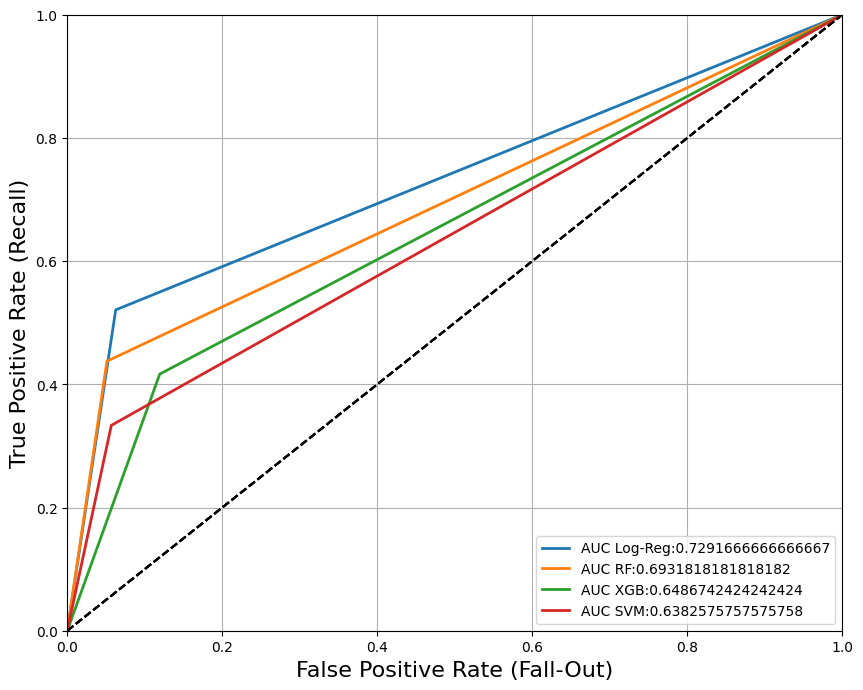

In [101]:
def plot_roc_curve(fpr, tpr, label = 'AUC= ' + str(auc)):
    """
    Plot the Receiver Operating Characteristic (ROC) curve for a binary classification model.

    Parameters:
    - fpr: An array of false positive rates.
    - tpr: An array of true positive rates.
    - label: A label to display in the plot, including the area under the curve (AUC).

    This function plots the ROC curve for a binary classification model using the false positive rates (fpr) and true positive rates (tpr).
    It also displays a dashed diagonal line and labels the axes.

    Usage:
    - Call this function to create an ROC curve plot for model evaluation.

    Example:
    plot_roc_curve(fpr, tpr, label='AUC=0.85')
    """
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(10, 8))                                  
plot_roc_curve(roc_curve(labels_val, y_pred_log)[0], roc_curve(labels_val, y_pred_log)[1], label = 'AUC Log-Reg:' + str(auc_log))
plot_roc_curve(roc_curve(labels_val, y_pred_rf)[0], roc_curve(labels_val, y_pred_rf)[1], label = 'AUC RF:' + str(auc_rf))
plot_roc_curve(roc_curve(labels_val, y_pred_xgb)[0], roc_curve(labels_val, y_pred_xgb)[1], label = 'AUC XGB:' + str(auc_xgb))
plot_roc_curve(roc_curve(labels_val, y_pred_svm)[0], roc_curve(labels_val, y_pred_svm)[1], label = 'AUC SVM:' + str(auc_svm))
plt.legend(loc = 4)
                                  
plt.show()

Logistic Regression seems to be the best model so far. The other models tend to overfit the training data and perform worse in the validation set, hence I will try to train the Random Forest and XGBoost models using Stratified KFold Cross Validation to deal with the fact that we have a somewhat small training set to train these models.

### Cross Validation

In [123]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'roc_auc' : make_scorer(roc_auc_score)}

cv = RepeatedStratifiedKFold(n_splits= 10, n_repeats= 5) # Use Stratified KFold as a evaluation method

# Random Forest
scores_rf = cross_validate(RandomForestClassifier(), df_train_prepared, np.ravel(labels), cv= cv, scoring= scoring, n_jobs= 10)

# XGBoost
scores_xgb = cross_validate(XGBClassifier(), df_train_prepared, np.ravel(labels), cv= cv, scoring= scoring, n_jobs= 10)

In [124]:
print('******* Metrics Random Forest *******')
print('Mean Accuracy: %.3f' % np.mean((scores_rf['test_accuracy'])))
print('Mean Precision: %.3f' % np.mean((scores_rf['test_precision'])))
print('Mean ROC AUC: %.3f' % np.mean((scores_rf['test_roc_auc'])))
print('Mean Recall: %.3f' % np.mean((scores_rf['test_recall'])))
print('Mean F1 Score: %.3f' % np.mean((scores_rf['test_f1_score'])))

print('******* Metrics XGBoost *******')
print('Mean Accuracy: %.3f' % np.mean((scores_xgb['test_accuracy'])))
print('Mean Precision: %.3f' % np.mean((scores_xgb['test_precision'])))
print('Mean ROC AUC: %.3f' % np.mean((scores_xgb['test_roc_auc'])))
print('Mean Recall: %.3f' % np.mean((scores_xgb['test_recall'])))
print('Mean F1 Score: %.3f' % np.mean((scores_xgb['test_f1_score'])))

******* Metrics Random Forest *******
Mean Accuracy: 0.826
Mean Precision: 0.666
Mean ROC AUC: 0.658
Mean Recall: 0.364
Mean F1 Score: 0.464
******* Metrics XGBoost *******
Mean Accuracy: 0.799
Mean Precision: 0.536
Mean ROC AUC: 0.656
Mean Recall: 0.407
Mean F1 Score: 0.459


Using Stratified KFold Cross Validation does not seem to improve the metrics on the Random Forest and XGBoost models.

### 5. Conclusions

In [135]:
scores_models = ['Sensitivity', 'Specificity', 'Precision(PPV)', 'NPV', 'FPR(Fall_Out)', 'F1_Score', 'ROC_AUC_Score']

model_comparison_metrics = pd.DataFrame(np.array([[recall_log, specificity_log, precision_log, npv_log, fpr_log, f1_score_log, auc_log],
                       [recall_rf, specificity_rf, precision_rf, npv_rf, fpr_rf, f1_score_rf, auc_rf],
                       [recall_xgb, specificity_xgb, precision_xgb, npv_xgb, fpr_xgb, f1_score_xgb, auc_xgb],
                       [recall_svm, specificity_svm, precision_svm, npv_svm, fpr_svm, f1_score_svm, auc_svm], 
                      ]), columns= scores_models, index= ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM'])

model_comparison_metrics

,Sensitivity,Specificity,Precision(PPV),NPV,FPR(Fall_Out),F1_Score,ROC_AUC_Score
Logistic Regression,0.520833,0.937500,0.694444,0.877660,0.062500,0.595238,0.729167
Random Forest,0.437500,0.948864,0.700000,0.860825,0.051136,0.538462,0.693182
XGBoost,0.416667,0.880682,0.487805,0.846995,0.119318,0.449438,0.648674
SVM,0.333333,0.943182,0.615385,0.838384,0.056818,0.432432,0.638258


<Axes: ylabel='Feature'>

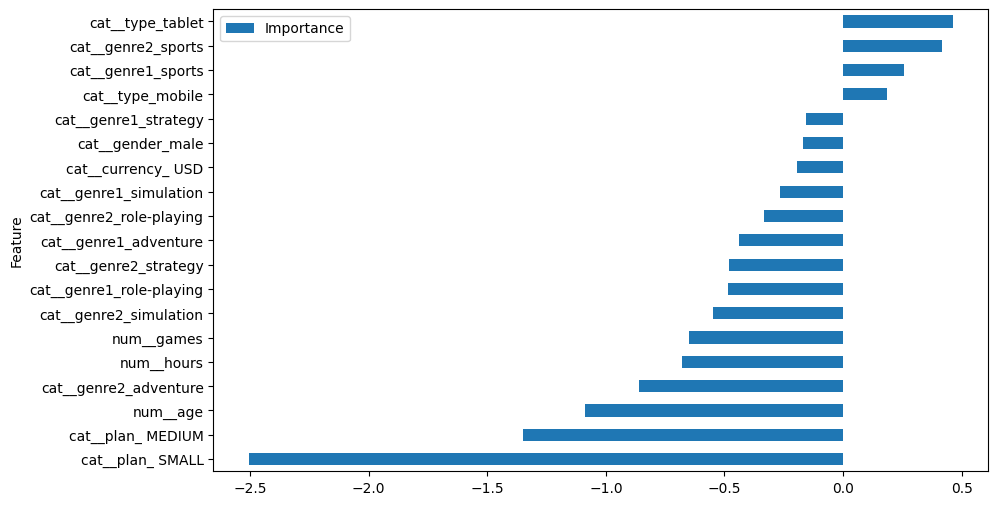

In [131]:
coefficients = log_reg.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train_prepared.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

The Logistic Regression model seems to be the best model to this type of data. 

### 6. Predictions

In [194]:
test_pred = log_reg.predict(df_test_prepared)
test_pred = list(test_pred)

# join with test set

test_df['Churn'] = test_pred
test_df

/var/folders/hs/t_th7f6j6tsb1fg2d7_808y80000gn/T/ipykernel_26763/3287119660.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Churn'] = test_pred


,gender,genre1,genre2,type,games,age,hours,Orders,Date_First_Order,Date_Last_Order,plan,currency,Churn
account_id,,,,,,,,,,,,,
7213516,female,adventure,adventure,computer,8,24,8.944547,6,2020-07-09,2020-12,SMALL,USD,0
7320093,male,adventure,strategy,tablet,5,23,12.182189,5,2020-08-24,2020-12,SMALL,EUR,1
7607756,male,adventure,sports,mobile,2,42,12.357027,4,2020-09-10,2020-12,SMALL,EUR,1
11173043,female,adventure,adventure,mobile,16,31,7.838690,3,2020-10-12,2020-12,SMALL,USD,1
15316204,male,sports,adventure,mobile,16,32,11.416764,6,2020-07-11,2020-12,SMALL,USD,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
993746799,female,adventure,role-playing,mobile,3,29,10.494169,6,2020-07-03,2020-12,SMALL,USD,1
993855537,male,role-playing,strategy,computer,8,36,7.301066,6,2020-07-29,2020-12,SMALL,EUR,0
994086312,male,strategy,adventure,mobile,7,17,8.575558,5,2020-08-01,2020-12,SMALL,USD,1


In [195]:
test_df.Churn.value_counts(dropna=False)

Churn
1    196
0     39
Name: count, dtype: int64

In [196]:
labels.value_counts(dropna=False)

Churn
0        881
1        238
Name: count, dtype: int64

In [206]:
train_df

,gender,genre1,genre2,type,games,age,hours,Orders,Date_First_Order,Date_Last_Order,plan,currency
account_id,,,,,,,,,,,,
101530,male,role-playing,action,mobile,8,21,7.573853,4,2019-09-03,2019-12,SMALL,EUR
731892,female,adventure,action,computer,9,25,4.620231,11,2020-02-12,2020-12,SMALL,EUR
856432,male,action,role-playing,mobile,19,35,13.608988,12,2020-01-25,2020-12,SMALL,EUR
2397506,male,adventure,role-playing,computer,13,32,7.151723,16,2019-09-06,2020-12,SMALL,USD
2436396,male,adventure,sports,mobile,10,25,14.455147,11,2019-02-18,2019-12,MEDIUM,USD
...,...,...,...,...,...,...,...,...,...,...,...,...
998070356,male,adventure,adventure,mobile,1,25,5.193802,8,2020-05-15,2020-12,SMALL,EUR
998103378,male,adventure,action,mobile,4,21,8.276883,3,2020-03-14,2020-05,SMALL,EUR
998392913,male,adventure,action,computer,13,42,9.213152,18,2019-07-03,2020-12,MEDIUM,USD


In [205]:
df_train_prepared

,num__games,num__age,num__hours,num__Orders,cat__gender_male,cat__genre1_adventure,cat__genre1_role-playing,cat__genre1_simulation,cat__genre1_sports,cat__genre1_strategy,cat__genre2_adventure,cat__genre2_role-playing,cat__genre2_simulation,cat__genre2_sports,cat__genre2_strategy,cat__type_mobile,cat__type_tablet,cat__plan_ MEDIUM,cat__plan_ SMALL,cat__currency_ USD
account_id,,,,,,,,,,,,,,,,,,,,
101530,-0.110475,-0.972409,-0.333935,-1.344634,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
731892,0.087004,-0.333744,-1.004339,-0.075809,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
856432,2.061794,1.262918,1.035902,0.105452,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2397506,0.876920,0.783920,-0.429749,0.830495,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2436396,0.284483,-0.333744,1.227960,-0.075809,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998070356,-1.492829,-0.333744,-0.874152,-0.619591,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
998103378,-0.900392,-0.972409,-0.174363,-1.525895,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
998392913,0.876920,2.380582,0.038148,1.193016,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [204]:
df_test_prepared

,num__games,num__age,num__hours,num__Orders,cat__gender_male,cat__genre1_adventure,cat__genre1_role-playing,cat__genre1_simulation,cat__genre1_sports,cat__genre1_strategy,cat__genre2_adventure,cat__genre2_role-playing,cat__genre2_simulation,cat__genre2_sports,cat__genre2_strategy,cat__type_mobile,cat__type_tablet,cat__plan_ MEDIUM,cat__plan_ SMALL,cat__currency_ USD
account_id,,,,,,,,,,,,,,,,,,,,
7213516,-0.110475,-0.493410,-0.022819,-0.982113,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
7320093,-0.702912,-0.653076,0.712051,-1.163373,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
7607756,-1.295350,2.380582,0.751735,-1.344634,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
11173043,1.469357,0.624254,-0.273823,-1.525895,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
15316204,1.469357,0.783920,0.538317,-0.982113,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993746799,-1.097871,0.304921,0.328910,-0.982113,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
993855537,-0.110475,1.422585,-0.395851,-0.982113,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
994086312,-0.307954,-1.611074,-0.106571,-1.163373,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


In [202]:
test_df[test_df.Churn==0]

,gender,genre1,genre2,type,games,age,hours,Orders,Date_First_Order,Date_Last_Order,plan,currency,Churn
account_id,,,,,,,,,,,,,
7213516,female,adventure,adventure,computer,8,24,8.944547,6,2020-07-09,2020-12,SMALL,USD,0
15316204,male,sports,adventure,mobile,16,32,11.416764,6,2020-07-11,2020-12,SMALL,USD,0
19155603,female,role-playing,adventure,mobile,3,28,8.876661,6,2020-07-23,2020-12,SMALL,EUR,0
43829746,male,adventure,adventure,computer,8,24,7.763471,6,2020-07-23,2020-12,SMALL,USD,0
103853772,female,adventure,strategy,mobile,15,26,8.347216,6,2020-07-16,2020-12,SMALL,USD,0
123515520,female,adventure,adventure,computer,8,26,12.171255,6,2020-07-17,2020-12,SMALL,USD,0
224192866,female,action,action,computer,13,34,9.305675,6,2020-07-01,2020-12,MEDIUM,EUR,0
275752484,male,adventure,adventure,mobile,16,29,8.915251,6,2020-07-07,2020-12,SMALL,EUR,0
322032560,male,action,strategy,mobile,6,35,9.821816,6,2020-07-15,2020-12,SMALL,USD,0


In [201]:
test_df[test_df.Churn==1]

,gender,genre1,genre2,type,games,age,hours,Orders,Date_First_Order,Date_Last_Order,plan,currency,Churn
account_id,,,,,,,,,,,,,
7320093,male,adventure,strategy,tablet,5,23,12.182189,5,2020-08-24,2020-12,SMALL,EUR,1
7607756,male,adventure,sports,mobile,2,42,12.357027,4,2020-09-10,2020-12,SMALL,EUR,1
11173043,female,adventure,adventure,mobile,16,31,7.838690,3,2020-10-12,2020-12,SMALL,USD,1
27664236,male,adventure,role-playing,mobile,22,33,22.162721,5,2020-08-28,2020-12,SMALL,EUR,1
30398911,female,simulation,strategy,computer,10,23,9.460995,5,2020-08-21,2020-12,LARGE,EUR,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
984672078,male,action,sports,computer,6,22,6.671755,4,2020-09-20,2020-12,SMALL,USD,1
993746799,female,adventure,role-playing,mobile,3,29,10.494169,6,2020-07-03,2020-12,SMALL,USD,1
994086312,male,strategy,adventure,mobile,7,17,8.575558,5,2020-08-01,2020-12,SMALL,USD,1
